In [1]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline 

In [2]:
#load data
data = pd.read_csv('loan_data.csv')
data.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


In [3]:
data.shape

(9578, 14)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


There are no null values

## Exploratory Data Analysis, Data Cleaning and Feature Engineering

### What is the target variable?

As this is binary classification problem(predict if a person would default), the only columns with binary values are 'not.fully.paid' and 'credit.policy'. The target here would be 'not.fully.paid', as it represents whether a customer paid the loan or not. It is possible that even when a customer meets the credit underwriting criteria of the bank, he still defaults due to some other factors. 

In [5]:
data = data.rename(columns = {'not.fully.paid' : 'target'})

### Is the data balanced or imbalanced? What are the different values that target variable takes?

In [6]:
data['target'].value_counts()

0    8045
1    1533
Name: target, dtype: int64

In [7]:
(8045/(8045+1533))*100

83.99457089162664

Clearly the data is biased towards class 0 as nearly 84 percent of instances belong to class 0. 

### Since it is to be classified whether a customer would default on a loan or not, does class 0 represent the customer would default or class 1?

As per the documentation, risky customers are assigned a higher interest rate. So we'll take a look at that. 

In [8]:
#group by target and take mean
df_target = data.groupby(['target']).mean()
df_target['int.rate']

target
0    0.120770
1    0.132452
Name: int.rate, dtype: float64

On average interest rate is higher for class 1. But are these means statistically different? Let's do a hypothesis testing here. 

H0 = the difference in means is 0

H1 = mean1 > mean0

In [9]:
#get data for class 0 and class 1
df0 = data[data['target']==0]
df1 = data[data['target']==1]

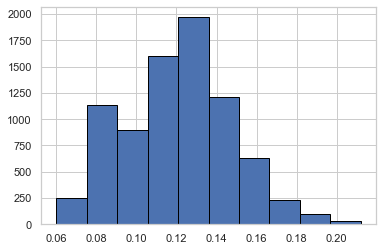

In [10]:
#distribution for class 0
sns.set_theme(style="whitegrid")
plt.hist(df0['int.rate'], histtype = 'bar', ec = 'black')
plt.savefig('df0.png')

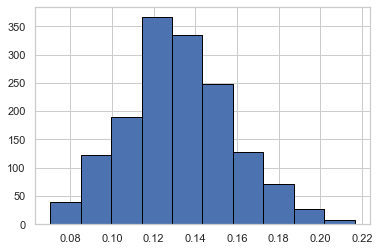

In [11]:
#distribution for class 1
plt.hist(df1['int.rate'], histtype = 'bar', ec = 'black')
plt.savefig('df1.png')

The samples are approximately normally distributed.

In [12]:
# define 2 sample z-test to output p value and z-statistic
def twoSampZ(X1, X2, mudiff, sd1, sd2, n1, n2):
    from numpy import sqrt, abs, round
    from scipy.stats import norm
    pooledSE = sqrt(sd1**2/n1 + sd2**2/n2)
    z = ((X1 - X2) - mudiff)/pooledSE
   # pval = 2*(1 - norm.cdf(abs(z)))
    pval = (1 - norm.cdf(abs(z)))
    return round(z, 3), round(pval, 4)

In [13]:
#perform 2 sample z-test
twoSampZ(df1['int.rate'].mean(),df0['int.rate'].mean(),0,df1['int.rate'].std(),
         df0['int.rate'].std(),df1.shape[0],df0.shape[0])

(16.317, 0.0)

A high z-statistic and p value < 0.05 indicates that we can reject the null hypothesis. What this means for our purpose is that interest for class 0 is significantly different from interest rate of class 1, and is statistically lower. So we can move forward with the assumption that class 0 stands for not default, class 1 stands for that the customer would default. 

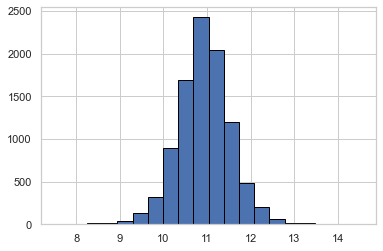

In [14]:
#plot the distribution of log annual income
plt.hist(data['log.annual.inc'], bins = 20, histtype='bar', ec = 'black')
plt.savefig('annual_income.png')

In [15]:
#check average income for class 0 and class 1
df_target['log.annual.inc']

target
0    10.941091
1    10.885023
Name: log.annual.inc, dtype: float64

The average income for class 1 is lower than class 0. Is this statistically different? A similar statistical test as of above can be conducted on log annual income. Our initial guess is higher the income, the person is less likely to default. Or in other words, the average income of people who don't default is higher than the average income of people who default. We can again conduct a two sample z-test

H0: mean0 = mean1

H1: mean0 > mean1

In [16]:
#perform 2 sample z-test on log.annual.income
twoSampZ(df0['log.annual.inc'].mean(),df1['log.annual.inc'].mean(),0,df0['log.annual.inc'].std(),
         df1['log.annual.inc'].std(),df0.shape[0],df1.shape[0])

(3.062, 0.0011)

p value is less than 0.05, so we can reject the null hypthesis that there is no difference in income of people who default vs who don't. In fact based on the given data it would be meaningful to conclude that the higher the income, people are less likely to default. 

We can also perform non-parametric tests on other features. For example, take a look at the debt to income ratio for group 0 and group 1. 

H0: mean1 = mean0

H1: mean1 > mean0


In [17]:
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(df0['dti'],df1['dti'], alternative = "less")
print(stat,p)

5817913.5 0.00022140977885724182


p-value is less than 0.05, so we can reject the null. This indicates that group 1 has higher debt to income ratio, and so we would expect them to default more. In fact, it can be argued that any difference would be significant due to large sample sizes. So, the differences for all the variables can be summarized in the following table

In [18]:
df_target

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec
target,,,,,,,,,,,,
0,0.832318,0.120770,314.574123,10.941091,12.494413,713.326911,4592.632624,16122.724425,45.759608,1.433934,0.161591,0.056557
1,0.661448,0.132452,342.785114,10.885023,13.195838,697.828441,4393.541259,21066.293542,52.255075,2.330724,0.174821,0.091324


It can be seen that class 1 has more interest rate, higher debt to income ratio, lower fico credit score, higher revolving balance, high utilization rate, more number of inquiries, more derogatory public records, more average number of days payment due past 30 days. Hence it's justified to assume they represent the risky customers who are more prone to default on the loan. 

### Q - What is the purpose behind different loans and what percent of them default?

In [19]:
# add a dummy column which only contains 1s, to perform calculations
data['count'] = 1

In [20]:
#groupby and count
data_purpose = data.groupby(['purpose','target']).count()

In [21]:
#add a percentage column
data_purpose['percentage']=data_purpose['count'].div(data_purpose['count'].sum(level=0),level=0)

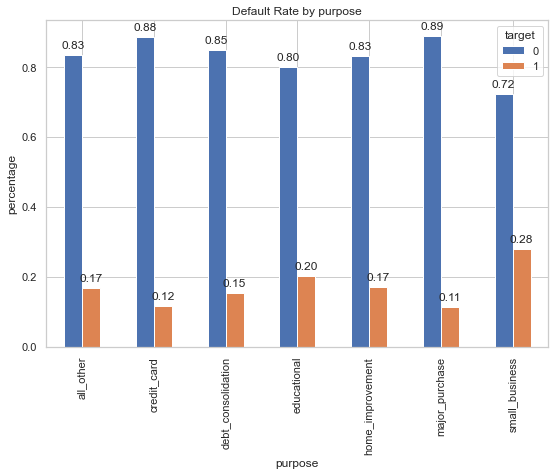

In [22]:
#plot the percentages in a grouped bar chart
ax = data_purpose['percentage'].unstack().plot(kind='bar', stacked=False, figsize = (9,6), title = 'Default Rate by purpose')
for p in ax.patches:
    ax.annotate(f'{p.get_height():0.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
ax.set_xlabel('purpose')
ax.set_ylabel('percentage')
plt.savefig('defratepurpose.png')

### What is the average income of different groups with different purpose?

In [23]:
#groupby purpose and take mean
data_pur_mean = data.groupby(['purpose']).mean()

In [24]:
#convert incomes to decimal scale from exponential
data_pur_mean['income'] = np.exp(data_pur_mean['log.annual.inc'])

In [25]:
#define a column names purpose to plot as axis
data_pur_mean['purpose'] = data_pur_mean['income'].index

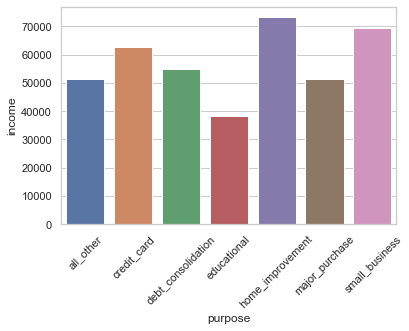

In [26]:
# plot a bar chart to compare different incomes 
sns.barplot(x = 'purpose', y = 'income', data = data_pur_mean[['income', 'purpose']])
plt.xticks(rotation=45)
plt.savefig('incomebypurpose.png')

### Does income affect likelihood of defaulting?

In [27]:
def income_category(log_income):
    if(log_income>0 and log_income<10):
        return 'poor'
    elif(log_income>=10 and log_income<11):
        return 'lower_middle'
    elif(log_income>=11 and log_income<12):
        return 'upper_middle'
    else:
        return 'rich'

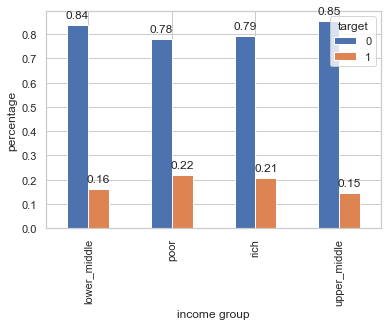

In [28]:
data['income_groups'] = data['log.annual.inc'].apply(income_category)
data_income = data.groupby(['income_groups','target']).count()
data_income['percentage']=data_income['count'].div(data_income['count'].sum(level=0),level=0)
ax2 = data_income['percentage'].unstack().plot(kind='bar', stacked=False)
for p in ax2.patches:
    ax2.annotate(f'{p.get_height():0.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
ax2.set_xlabel('income group')
ax2.set_ylabel('percentage')
plt.savefig('defrateincome.png')


In [29]:
default_rate_df = data.groupby(['income_groups']).sum()
default_rate_df['default_rate'] = default_rate_df['target']/default_rate_df['count']
default_rate_df['default_rate']

income_groups
lower_middle    0.160876
poor            0.218150
rich            0.208219
upper_middle    0.146809
Name: default_rate, dtype: float64

Text(0, 0.5, 'default rate')

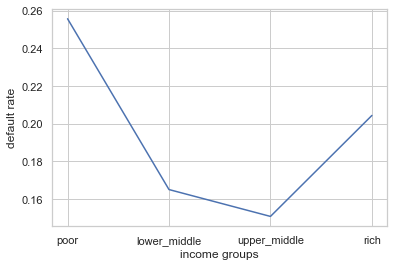

In [30]:
df_rate = pd.DataFrame({'category':['poor', 'lower_middle', 'upper_middle', 'rich'], 'default_rate': [0.255639, 0.164953, 0.150694, 0.204301]})
df_rate.set_index('category', inplace=True)
plt.plot(df_rate.index, df_rate['default_rate'])
plt.xlabel('income groups')
plt.ylabel('default rate')

This shows that default rate decreases at first as income increases and then increases again, but not as much as it began with. A more exhaustive analysis is done in the outliers analysis section, where the intervals are shorter. 

### How accurate is credit underwriting score? Do more people who don't meet the criteria default?

In [31]:
#groupby credit policy and target and count total instances
df_credit = data.groupby(['credit.policy', 'target']).count()

In [32]:
#calculate percentage for each group
df_credit['percentage']=df_credit['count'].div(df_credit['count'].sum(level=0),level=0)

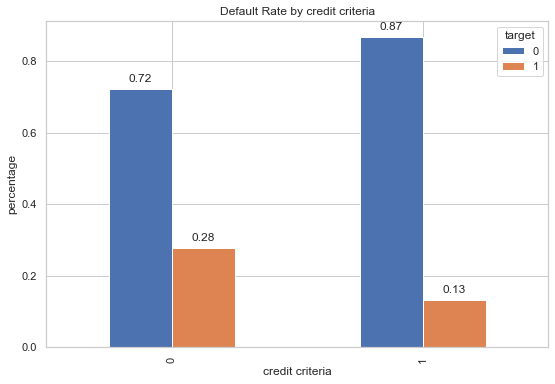

In [33]:
#plot the percentages in a grouped bar chart
ax1 = df_credit['percentage'].unstack().plot(kind='bar', stacked=False, figsize = (9,6), title = 'Default Rate by credit criteria')
for p in ax1.patches:
    ax1.annotate(f'{p.get_height():0.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
ax1.set_xlabel('credit criteria')
ax1.set_ylabel('percentage')
plt.savefig('creditcriteria.png')

It can be seen that when customer meets the credit underwriting criteria the chances that he'd default reduce by more than 50 percent. 

In [34]:
#drop the dummy columns
data = data.drop(columns=['count','income_groups'])


## Data Cleaning and Feature Engineering

### Which features are categorical, numerical?

In [35]:
#numerical columns
data.select_dtypes(include = ['int64','float64']).columns

Index(['credit.policy', 'int.rate', 'installment', 'log.annual.inc', 'dti',
       'fico', 'days.with.cr.line', 'revol.bal', 'revol.util',
       'inq.last.6mths', 'delinq.2yrs', 'pub.rec', 'target'],
      dtype='object')

In [36]:
#categorical columns
data.select_dtypes(include = ['object']).columns

Index(['purpose'], dtype='object')

In [37]:
#other columns
data.select_dtypes(exclude = ['int64', 'float64', 'object']).columns

Index([], dtype='object')

#### One hot encoding

In [38]:
data_onehot = pd.concat([pd.get_dummies(data['purpose'],drop_first=True), 
                         data.drop(['purpose'],axis=1)], axis=1)

### Which features are correlated?

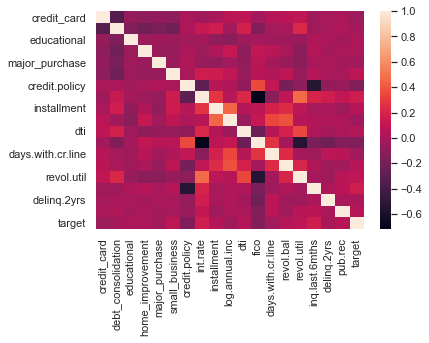

In [39]:
sns.heatmap(data_onehot.corr())
plt.savefig('corr.png')

In [40]:
#find out highly correlated features
cols = data_onehot.columns
for col in cols :
    for col1 in cols:
        corr = data_onehot[col].corr(data_onehot[col1])
        if(corr)>0.70 or corr<-0.70:
            if(col!=col1):
                print(col, " ", col1, " :", corr) 

int.rate   fico  : -0.7148207714193597
fico   int.rate  : -0.7148207714193598


#### Remove highly correlated features. 

In [41]:
data_corr = data_onehot.drop(columns = ['int.rate'])

### Outliers Analysis

In [42]:
Q1 = data_corr.quantile(0.25)
Q3 = data_corr.quantile(0.75)
IQR = Q3-Q1

In [43]:
lower = (Q1 - 1.5*IQR)
upper = (Q3 + 1.5*IQR)

#### Calculate no. of data points above the upper limit (upper_count) and no. of points below the lower limit (lower_count)

In [44]:
dic = {}
for colm in data_corr.columns:
    dic[colm] = data_corr[data_corr[colm]>upper[colm]].shape[0] 
upper_count = pd.Series(dic)

dic1 = {}
for colm in data_corr.columns:
    dic1[colm] = data_corr[data_corr[colm]<lower[colm]].shape[0] 
lower_count = pd.Series(dic1)


In [45]:
#create a dataframe for outliers
dictdf = {'Q1':Q1, 'Q3':Q3, 'IQR':IQR, 'lower': lower, 'lower_count' : lower_count , 'upper': upper, 
          'upper_count':upper_count,'max' : data_corr.max(), 'min':data_corr.min()}
outliers = pd.DataFrame(dictdf)
outliers


,Q1,Q3,IQR,lower,lower_count,upper,upper_count,max,min
credit_card,0.000000,0.000000,0.000000,0.000000,0,0.000000,1262,1.000000e+00,0.000000
debt_consolidation,0.000000,1.000000,1.000000,-1.500000,0,2.500000,0,1.000000e+00,0.000000
educational,0.000000,0.000000,0.000000,0.000000,0,0.000000,343,1.000000e+00,0.000000
home_improvement,0.000000,0.000000,0.000000,0.000000,0,0.000000,629,1.000000e+00,0.000000
major_purchase,0.000000,0.000000,0.000000,0.000000,0,0.000000,437,1.000000e+00,0.000000
small_business,0.000000,0.000000,0.000000,0.000000,0,0.000000,619,1.000000e+00,0.000000
credit.policy,1.000000,1.000000,0.000000,1.000000,1868,1.000000,0,1.000000e+00,0.000000
installment,163.770000,432.762500,268.992500,-239.718750,0,836.251250,236,9.401400e+02,15.670000
log.annual.inc,10.558414,11.291293,0.732879,9.459094,117,12.390612,121,1.452835e+01,7.547502
dti,7.212500,17.950000,10.737500,-8.893750,0,34.056250,0,2.996000e+01,0.000000


The following columns have 0 InterQuartile Range and therefore can be excluded from outlier analysis. Also the feature debt_consolidation can only take values 0 or 1, so it's IQR being 1 is meaningless, and revol.util and dti have zero outliers. All of these columns do not need any investigation.  

In [46]:
#columns with IQR zero
col1 = ['credit_card','debt_consolidation', 'educational','home_improvement','major_purchase','small_business', 'dti', 'revol.util',
        'credit.policy','delinq.2yrs','pub.rec','target']

Next we need to investigate if the outliers are present by chance or is it the variation of data. 

In [47]:
#define a method to get default rate as a particular feature varies, by dividing it into discrete intervals
def getDefaultRate(data,step, columnName):
    ratelist = []
    min_ = data[columnName].min()
    max_ = data[columnName].max()
    intervals = np.arange(min_,max_+step,step)
    for i in range(len(intervals)-1):
        print(intervals[i], intervals[i+1])
        tarseriesq = data[(data[columnName]>intervals[i]) & (data[columnName]<=intervals[i+1])]['target'].value_counts(normalize=True)
        if((1 not in tarseriesq.index) or len(tarseriesq)==0 ):
            ratelist.append(0)                
        else:
            ratelist.append(tarseriesq[1])
    return intervals[:-1]+step/2,ratelist
    

In [48]:
#define a method to plot default rate, upper lower outlier limit by IQR, on top of histogram of the same
def plotDefaultRate(data, columnName):
    n,bins,patches = plt.hist(data[columnName], weights=np.ones(len(data[columnName])) / len(data[columnName]), color = 'skyblue',
                             label = "class frequency")
    step = bins[1]-bins[0]
   
    intervals, ratelist = getDefaultRate(data, step, columnName)
    plt.plot(intervals,ratelist, color='g', label = 'defaut rate')
    plt.axvline(x = outliers.loc[columnName,'lower'], color = 'r', linestyle='--')
    plt.axvline(x = outliers.loc[columnName,'upper'], color = 'r', linestyle='--')
    plt.scatter(intervals,ratelist)
    plt.plot(np.unique(intervals), np.poly1d(np.polyfit(intervals, ratelist, 1))(np.unique(intervals)), linestyle = '--', label = 'best fit')
    plt.xlabel(columnName)
    plt.ylabel('default rate')
    plt.legend()
    


0.0 3.3
3.3 6.6
6.6 9.899999999999999
9.899999999999999 13.2
13.2 16.5
16.5 19.799999999999997
19.799999999999997 23.099999999999998
23.099999999999998 26.4
26.4 29.7
29.7 33.0
7.547501682999999 8.2455869627
8.2455869627 8.943672242399998
8.943672242399998 9.641757522099999
9.641757522099999 10.3398428018
10.3398428018 11.037928081499999
11.037928081499999 11.736013361199998
11.736013361199998 12.434098640899999
12.434098640899999 13.1321839206
13.1321839206 13.830269200299998
13.830269200299998 14.528354479999997
14.528354479999997 15.226439759699998
15.67 108.117
108.117 200.564
200.564 293.011
293.011 385.458
385.458 477.90500000000003
477.90500000000003 570.352
570.352 662.799
662.799 755.246
755.246 847.693
847.693 940.14
0.0 120735.9
120735.9 241471.8
241471.8 362207.69999999995
362207.69999999995 482943.6
482943.6 603679.5
603679.5 724415.3999999999
724415.3999999999 845151.2999999999
845151.2999999999 965887.2
965887.2 1086623.0999999999
1086623.0999999999 1207359.0
612.0 633.5

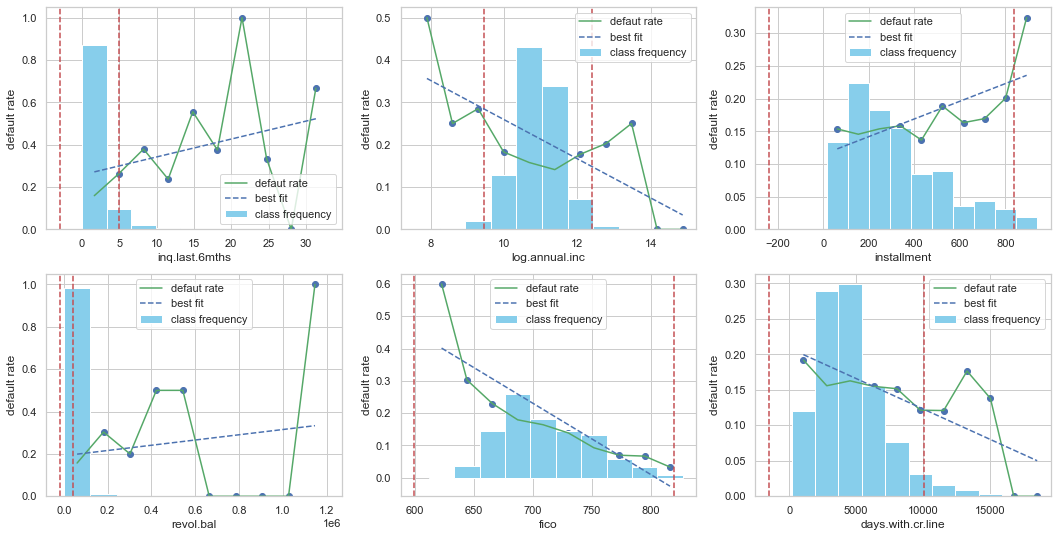

In [49]:
plt.rcParams["figure.figsize"] = (18,9) 
plt.subplot(231)
plotDefaultRate(data_corr,'inq.last.6mths')
plt.subplot(232)
plotDefaultRate(data_corr,'log.annual.inc')
plt.subplot(233)
plotDefaultRate(data_corr,'installment')
plt.subplot(234)
plotDefaultRate(data_corr,'revol.bal')
plt.subplot(235)
plotDefaultRate(data_corr,'fico')
plt.subplot(236)
plotDefaultRate(data_corr,'days.with.cr.line')
plt.savefig('outliercols.png')

Description: Default Rate is defined as number of 0s divided by total counts in the target variable corresponding to a class interval in  various features. It is represented by the green line. The blue histogram is the distribution of the given feature. The interval for default rate is the same as that of histogram which algorithmically computed. The red verticle dotted lines are the left and right outliers at 1.5 * IQR. The blue dotted line shows the best fit line. The default rate has been plotted on top of the histogram to show its relative importance with respect to the number of data points it covers. 

There are 2 major inferences from these graphs. 

1. It visually demonstrates what I earlier computed with statistical testing: how likely someone is to default when the feature takes on different values. The positive slope of the best fit line indicates that as the feature value increases, the likelihood of default increases and vice versa. 

2. It demonstrates the variation of outliers, when outliers are defined by 1.5 * IQR method. The best fit line shows that whatever trend there is during the volumne of data(where histograms are) remains the same during the range of outliers, with fluctuations. These fluctuations are not important as the number of data points they span on are very few compared to the trend, which can be easily demonstrated. Therefore, these outliers shouldn't be removed as they present useful information pertaining to the data at hand.  

It might be helpful to see the default rate in the outlier region:

In [50]:
defdict = {}
normdict = {}
for col in outliers.index:
    if(col not in col1):
        default_rate_outlier = data_corr[data_corr[col]>outliers.loc[col,'upper']]['target'].value_counts(normalize=True)[1]
        defdict[col] = default_rate_outlier
        default_rate_normal =  data_corr[(data_corr[col]<outliers.loc[col,'upper']) & (data_corr[col]>outliers.loc[col,'lower'])]['target'].value_counts(normalize=True)[1]
        normdict[col] = default_rate_normal
    else:
        defdict[col] = 0
        normdict[col] = 0
outliers['default_rate_outliers'] =  pd.Series(defdict)
outliers['default_rate_normal'] = pd.Series(normdict)
outliers[outliers['default_rate_normal']>0][['default_rate_normal', 'default_rate_outliers']]

,default_rate_normal,default_rate_outliers
installment,0.156712,0.292373
log.annual.inc,0.158458,0.190083
fico,0.160050,0.166667
days.with.cr.line,0.161395,0.124277
revol.bal,0.154922,0.217949
inq.last.6mths,0.146112,0.351464


As can be seen from this table, default rate follows the same trend in the outlier region as in the normal region (except fico, which indicates erroneous data). That is, when default rate has a positive slope, it comes out to be higher in the outlier region, and when it has a negative slope, it comes out to be lower in the outlier region. This suggests that outliers are merely extreme values which provide useful information for the model. It may not be wise to remove these outliers as is. However, these extreme values  make the distribution highly skewed and would affect the scaling of the data, which is not so good for the model. So, we will do a series of log transformations on these features and then remove the outliers. 

## Feature Transformation and Outlier removal

In [51]:
data_corr['log.revol.bal'] = np.log(data_corr['revol.bal'] + 1)

In [52]:
data_corr['log.days.with.cr.line'] = np.log(data_corr['days.with.cr.line'])

In [53]:
data_corr['log.installment'] = np.log(data_corr['installment'])

In [54]:
data_corr['log.inq.last.6mths'] = np.log(data_corr['inq.last.6mths'] + 1)

In [55]:
#define a method to plot default rate along with histogram, kdeplot and best fit line for default rate
def plotDefaultRateTransformed(data,column):
    n,bins,patches = plt.hist(data[column], weights=np.ones(len(data[column])) / len(data[column]), color = 'skyblue',
                             label = "class frequency")
    step = bins[1]-bins[0]
   
    intervals, ratelist = getDefaultRate(data, step, column)
    plt.plot(intervals,ratelist, color='g', label = 'default rate')
    plt.scatter(intervals,ratelist)
    sns.kdeplot(data[column])
    plt.plot(np.unique(intervals), np.poly1d(np.polyfit(intervals, ratelist, 1))(np.unique(intervals)), linestyle = '--', label = 'best fit')
    plt.title(column)
    plt.legend()
    

In [56]:
colnew = ['log.revol.bal', 'log.installment', 'log.days.with.cr.line', 'log.inq.last.6mths']

In [57]:
#remove old columns
data_cleaned = data_corr.drop(columns = ['revol.bal','installment','days.with.cr.line', 'inq.last.6mths'])

In [58]:
#update Q1, Q3 and IQR as calculated earlier for new columns
for col in colnew:
    Q1[col] = data_cleaned[col].quantile(0.25)
    Q3[col] = data_cleaned[col].quantile(0.75)
IQR = Q3-Q1

In [59]:
#columns where outliers need to be treated
cols = ['log.revol.bal', 'log.annual.inc', 'fico', 'log.inq.last.6mths', 'log.installment', 'log.days.with.cr.line']

In [60]:
#Remove outliers as per 1.5*IQR rule
data_ol = data_cleaned
for col in cols:
        low = Q1[col] - 1.5*IQR[col]
        high = Q3[col] + 1.5*IQR[col]
        data_ol = data_ol[~((data_ol[col]<low)|(data_ol[col]>high))]
        print(len(data_ol))

8980
8792
8787
8763
8660
8522


5.455321115357702 6.15210117010625
6.15210117010625 6.848881224854798
6.848881224854798 7.545661279603347
7.545661279603347 8.242441334351895
8.242441334351895 8.939221389100442
8.939221389100442 9.636001443848992
9.636001443848992 10.33278149859754
10.33278149859754 11.029561553346088
11.029561553346088 11.726341608094636
11.726341608094636 12.423121662843185
12.423121662843185 13.119901717591734
3.6410013738694724 3.960078252630284
3.960078252630284 4.279155131391096
4.279155131391096 4.598232010151907
4.598232010151907 4.917308888912719
4.917308888912719 5.23638576767353
5.23638576767353 5.555462646434342
5.555462646434342 5.8745395251951535
5.8745395251951535 6.193616403955965
6.193616403955965 6.512693282716777
6.512693282716777 6.831770161477588
6.890609120147166 7.1717465257649895
7.1717465257649895 7.452883931382813
7.452883931382813 7.734021337000636
7.734021337000636 8.015158742618459
8.015158742618459 8.296296148236282
8.296296148236282 8.577433553854105
8.577433553854105 8.

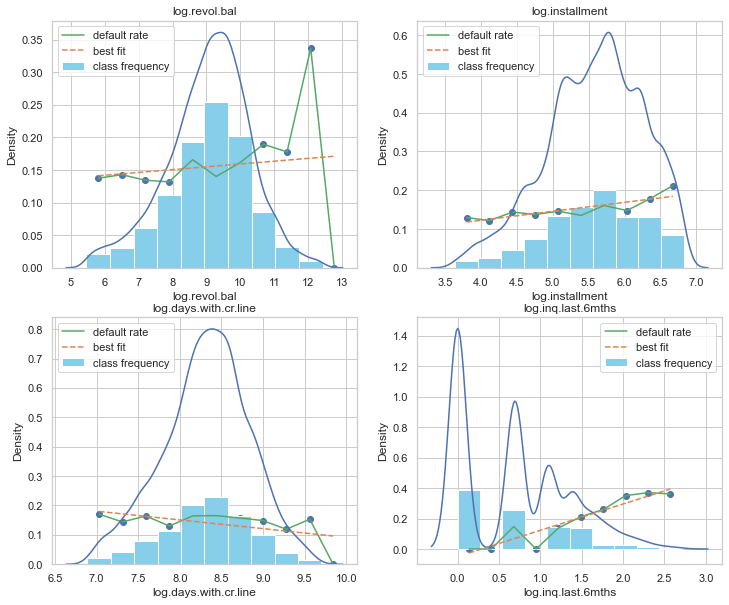

In [61]:
#plot transformed columns
plt.rcParams['figure.figsize'] = (12,10)
for i,col in enumerate(colnew):
    plt.subplot(2,2,i+1)
    plotDefaultRateTransformed(data_ol, col)
plt.savefig('transformedcols.png')

As can be seen, the initial trend is conserved

In [62]:
data_ol.shape

(8522, 18)

In [63]:
data_ol.columns

Index(['credit_card', 'debt_consolidation', 'educational', 'home_improvement',
       'major_purchase', 'small_business', 'credit.policy', 'log.annual.inc',
       'dti', 'fico', 'revol.util', 'delinq.2yrs', 'pub.rec', 'target',
       'log.revol.bal', 'log.days.with.cr.line', 'log.installment',
       'log.inq.last.6mths'],
      dtype='object')

## Oversampling

As was noted earlier, the dataset is highly imbalanced, which creates the problem of low precision and recall on the validation set. So a solution to that problem is do oversampling the minority class. We perform this by using Synthetic Minority Oversampling Technique (SMOTE) from imbalanced learn. 

In [64]:
from imblearn.over_sampling import SMOTE

In [65]:
smote = SMOTE()

In [66]:
X = data_ol.drop(columns = ['target'])
y = data_ol.target

In [67]:
X_smote, y_smote = smote.fit_resample(X,y)

In [68]:
y_smote.value_counts()

1    7197
0    7197
Name: target, dtype: int64

In [69]:
from sklearn.model_selection import train_test_split

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X_smote,y_smote,random_state = 10)

## Normalization

We shall now normalize the data from 0-1 to bring all features to the same scale

In [71]:
from sklearn.preprocessing import MinMaxScaler

In [72]:
mms = MinMaxScaler()

In [73]:
mms.fit(X_train)

MinMaxScaler()

In [74]:
X_train_std = mms.transform(X_train)
X_test_std = mms.transform(X_test)

In [75]:
X_train_std.shape[1]

17

In [76]:
X_train_std.shape[0]

10795

## Model Building and Training

In [77]:
from keras.models import Sequential
from keras.layers import Dense
from keras.metrics import Recall, Precision


In [78]:
model = Sequential()

model.add(Dense(64,input_dim = X_train_std.shape[1], activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = 'adam', loss= 'binary_crossentropy', metrics = ['accuracy',Recall(), Precision()] )
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1152      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 13,633
Trainable params: 13,633
Non-trainable params: 0
_________________________________________________________________


In [79]:
from livelossplot import PlotLossesKeras

In [80]:
from keras.callbacks import ModelCheckpoint
filepath = 'weights_best4.hdf5'
checkpoint = ModelCheckpoint(filepath,monitor = 'val_accuracy',verbose = 1, save_best_only=True, mode='max')

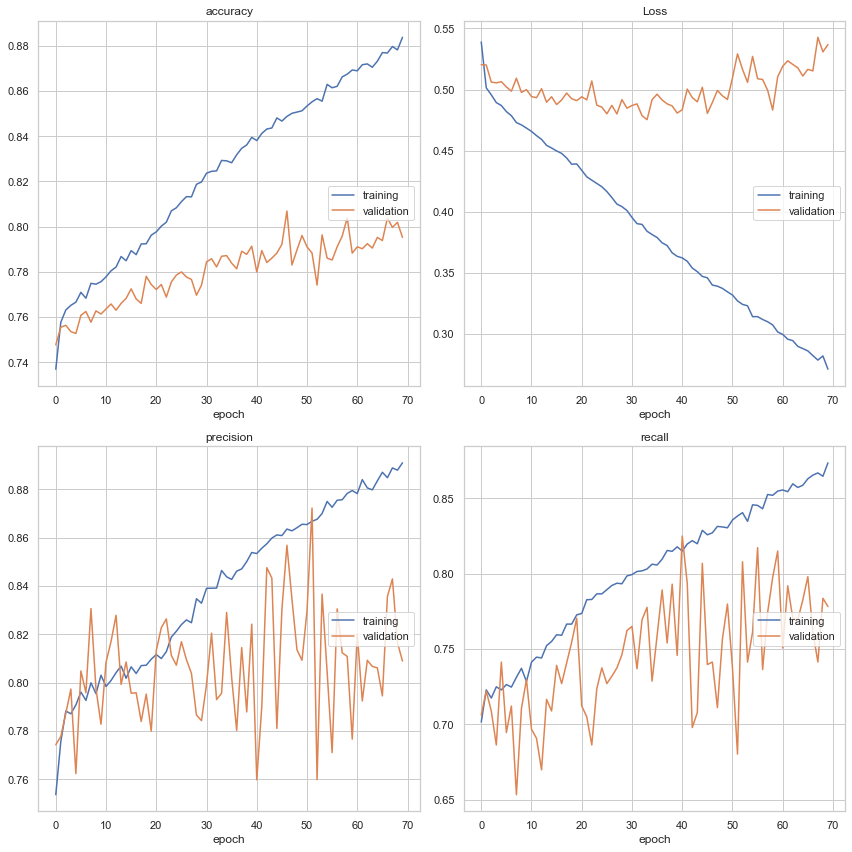

accuracy
	training         	 (min:    0.737, max:    0.884, cur:    0.884)
	validation       	 (min:    0.748, max:    0.807, cur:    0.795)
Loss
	training         	 (min:    0.271, max:    0.539, cur:    0.271)
	validation       	 (min:    0.475, max:    0.543, cur:    0.537)
precision
	training         	 (min:    0.754, max:    0.891, cur:    0.891)
	validation       	 (min:    0.760, max:    0.872, cur:    0.809)
recall
	training         	 (min:    0.701, max:    0.874, cur:    0.874)
	validation       	 (min:    0.653, max:    0.825, cur:    0.778)

Epoch 00070: val_accuracy did not improve from 0.80689


In [81]:
model.fit(X_train_std,y_train,epochs=70,callbacks=[PlotLossesKeras(), checkpoint],
          validation_data=(X_test_std, y_test), batch_size=32)

In [82]:
score_test = {'loss':[], 'accuracy':[], 'recall':[],'precision':[]}
score_train = {'loss':[], 'accuracy':[], 'recall':[],'precision':[]}

In [83]:
def addToDictionary():
    scores0 = model.evaluate(X_test_std,y_test)
    scores01 = model.evaluate(X_train_std, y_train)
    for i,metric in enumerate(model.metrics_names):
        score_test[metric].append(scores0[i])
        score_train[metric].append(scores01[i])

In [84]:
model.load_weights("weights_best1.hdf5")
addToDictionary()
model.load_weights('weights_best2.hdf5')
addToDictionary()
model.load_weights('weights_best3.hdf5')
addToDictionary()
model.load_weights('weights_best4.hdf5')
addToDictionary()

338/338 [==============================] - 1s 2ms/step - loss: 0.3273 - accuracy: 0.8545 - recall: 0.8004 - precision: 0.8965


In [85]:
indices = ['first_run', 'second_run', 'third_run', 'fourth_run']
testscores = pd.DataFrame(score_test, index = indices)
trainscores = pd.DataFrame(score_train, index = indices)

In [86]:
testscores

,loss,accuracy,recall,precision
first_run,0.542010,0.804112,0.798019,0.810962
second_run,0.529641,0.806891,0.790314,0.820571
third_run,0.544347,0.801889,0.765548,0.828963
fourth_run,0.489454,0.806891,0.741332,0.856870


In [87]:
trainscores

,loss,accuracy,recall,precision
first_run,0.305005,0.870032,0.850186,0.884548
second_run,0.286790,0.874479,0.848141,0.894530
third_run,0.295601,0.872997,0.827323,0.909667
fourth_run,0.327305,0.854470,0.800372,0.896523


In [88]:
testscores.describe().loc['mean']

loss         0.526363
accuracy     0.804946
recall       0.773803
precision    0.829342
Name: mean, dtype: float64

In [89]:
trainscores.describe().loc['mean']

loss         0.303675
accuracy     0.867994
recall       0.831506
precision    0.896317
Name: mean, dtype: float64

Mean Test scores rounded off to 3 places

In [92]:
round(testscores.describe().loc['mean'],3)

loss         0.526
accuracy     0.805
recall       0.774
precision    0.829
Name: mean, dtype: float64

Mean Train Scores rounded off to 3 places

In [93]:
round(trainscores.describe().loc['mean'],3)

loss         0.304
accuracy     0.868
recall       0.832
precision    0.896
Name: mean, dtype: float64